# Data upload

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/food.zip' .
!unzip -q food.zip
!rm food.zip

# Initialization

In [ ]:
!pip install split-folders tqdm

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders

# constants
DATA_DIR = '/content/food-101/images'
SETS_DIR = '/content/sets'
BATCH_SIZE = 256

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ' , device_name)

GPU:  /device:GPU:0


In [ ]:
# remove corrupted images
# taken from keras doc
# modified to remove also mac conf files

num_skipped = 0
for folder_name in os.listdir(DATA_DIR):
    if folder_name == '.DS_Store':
      ds_store = os.path.join(DATA_DIR, folder_name)
      os.remove(ds_store)
      print("Removed: ", ds_store)
    else:
      folder_path = os.path.join(DATA_DIR, folder_name)
      for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
          fobj = open(fpath, "rb")
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
          fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            print("Removed: ", fpath)

print("Removed %d images" % num_skipped)

Removed:  /content/food-101/images/.DS_Store
Removed 0 images


# Datasets creation

In [ ]:
# split data into train, validation and test set
splitfolders.ratio(DATA_DIR, output=SETS_DIR, seed=123, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 101000 files [02:16, 738.51 files/s]


In [ ]:
train = SETS_DIR + '/train/'
val = SETS_DIR + '/val/'
test = SETS_DIR + '/test/'

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True, 
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

# use buffered prefetching so we can yield data 
# from disk without having I/O becoming blocking
train_set = train_set.prefetch(buffer_size=BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=BATCH_SIZE)
test_set = test_set.prefetch(buffer_size=BATCH_SIZE)

Found 70700 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.


In [ ]:
def preprocess(images, labels):
  images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
  return images, labels
  
train_set = train_set.map(preprocess, deterministic=True)
val_set = val_set.map(preprocess, deterministic=True)
test_set = test_set.map(preprocess, deterministic=True)


# Training

In [ ]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3),
)

mobilenetv2.trainable = False

model = tf.keras.models.Sequential([
  # data augmentation
  tf.keras.Input(shape=(224,224,3)),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2, seed=123, fill_mode='nearest'),

  # basenet
  mobilenetv2,
  tf.keras.layers.GlobalAveragePooling2D(),

  # classifier
  tf.keras.layers.Dense(256, activation='relu', name='dense_hidden'),
  tf.keras.layers.Dense(101, activation='softmax', name='output')

], name='food_classifier')

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "food_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               327936    
_________________________________________________________________
output (Dense)               (None, 101)               25957     
Total params: 2,611,877
Trainable params: 353,893
Non-

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

callbacks = [
    # early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2,
        restore_best_weights=True),

    # model checkpoints (save the best model)
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        filepath='/content/gdrive/MyDrive/model/food_classifier.h5'),
]

history = model.fit(
      train_set,
      epochs=100,
      verbose=1,
      callbacks=callbacks,
      validation_data=val_set,
      batch_size=BATCH_SIZE)

Epoch 1/100
277/277 [==============================] - 325s 1s/step - loss: 4.2359 - accuracy: 0.0990 - val_loss: 2.9484 - val_accuracy: 0.3338
Epoch 2/100
277/277 [==============================] - 314s 1s/step - loss: 2.7665 - accuracy: 0.3647 - val_loss: 2.3205 - val_accuracy: 0.4410
Epoch 3/100
277/277 [==============================] - 292s 1s/step - loss: 2.2940 - accuracy: 0.4467 - val_loss: 2.1010 - val_accuracy: 0.4817
Epoch 4/100
277/277 [==============================] - 236s 835ms/step - loss: 2.0896 - accuracy: 0.4825 - val_loss: 1.9840 - val_accuracy: 0.5007
Epoch 5/100
277/277 [==============================] - 235s 833ms/step - loss: 1.9837 - accuracy: 0.5062 - val_loss: 1.9061 - val_accuracy: 0.5183
Epoch 6/100
277/277 [==============================] - 235s 833ms/step - loss: 1.9049 - accuracy: 0.5216 - val_loss: 1.8620 - val_accuracy: 0.5263
Epoch 7/100
277/277 [==============================] - 234s 829ms/step - loss: 1.8447 - accuracy: 0.5322 - val_loss: 1.8192 - v

In [ ]:
# unfreeze the last block of the MobileNetV2
mobilenetv2.trainable = True

train = False
for layer in mobilenetv2.layers:
    if layer.name == 'block_16_expand':
        train = True
    if train:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "food_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               327936    
_________________________________________________________________
output (Dense)               (None, 101)               25957     
Total params: 2,611,877
Trainable params: 1,239,973
Non-trainable params: 1,371,904
_________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

ft_history = model.fit(
      train_set,
      epochs=100,
      verbose=1,
      callbacks=callbacks,
      validation_data=val_set,
      batch_size=BATCH_SIZE
)

Epoch 1/100
277/277 [==============================] - 239s 835ms/step - loss: 2.0993 - accuracy: 0.4839 - val_loss: 1.7020 - val_accuracy: 0.5706
Epoch 2/100
277/277 [==============================] - 234s 832ms/step - loss: 1.6688 - accuracy: 0.5679 - val_loss: 1.6637 - val_accuracy: 0.5799
Epoch 3/100
277/277 [==============================] - 235s 834ms/step - loss: 1.5773 - accuracy: 0.5883 - val_loss: 1.6205 - val_accuracy: 0.5881
Epoch 4/100
277/277 [==============================] - 235s 834ms/step - loss: 1.5214 - accuracy: 0.6013 - val_loss: 1.5966 - val_accuracy: 0.5942
Epoch 5/100
277/277 [==============================] - 234s 831ms/step - loss: 1.4761 - accuracy: 0.6108 - val_loss: 1.5742 - val_accuracy: 0.5971
Epoch 6/100
277/277 [==============================] - 239s 846ms/step - loss: 1.4408 - accuracy: 0.6189 - val_loss: 1.5600 - val_accuracy: 0.6011
Epoch 7/100
277/277 [==============================] - 237s 839ms/step - loss: 1.4173 - accuracy: 0.6270 - val_loss: 1

# Evaluation

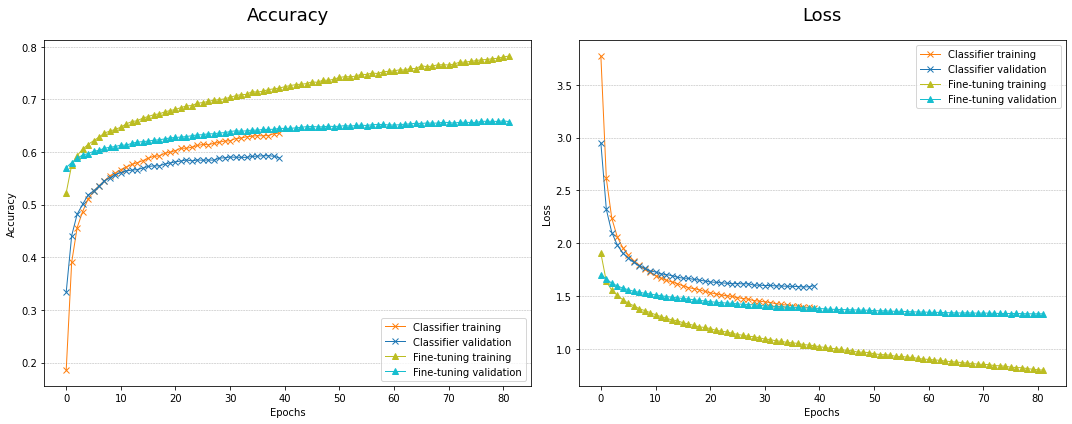

In [ ]:
# data from training with freezed mobilenet
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# data from fine-tuning training
ft_acc = ft_history.history['accuracy']
ft_val_acc = ft_history.history['val_accuracy']
ft_loss = ft_history.history['loss']
ft_val_loss = ft_history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))
epochs_1 = range(len(ft_acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:orange', marker='x', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.plot(epochs_1, ft_acc, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs_1, ft_val_acc, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, color='tab:orange', marker='x', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.plot(epochs_1, ft_loss, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs_1, ft_val_loss, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

# save graph
fig.savefig('train_plots.png')

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/model/food_classifier.h5')
test_loss, test_accuracy = model.evaluate(test_set)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

60/60 [==============================] - 60s 804ms/step - loss: 1.3128 - accuracy: 0.6626
Test loss:  1.3127570152282715
Test accuracy:  0.6626402735710144
